In [1]:
# Importing necessary libraries
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from utils_Sean import preprocess_and_cache, CachedMidiDataset, stratified_split, make_weighted_sampler_and_loss, CNNBiLSTMClassifier, EarlyStopping, train_and_evaluate, CNNBiLSTMClassifier2, CNNBiLSTMAttentionClassifier, CNNBiLSTMAttentionClassifier2, evaluate_confusion_matrix

In [2]:
# Checking that preprocessing with pretty_midi is working correctly
root_midi_dir = "midiclassics"
cache_output_dir = "cache_dir"

preprocess_and_cache(
    root_dir=root_midi_dir,
    out_dir=cache_output_dir,
    fs=100,
    max_length=1000,
    allowed_composers=['Bach', 'Chopin', 'Mozart', 'Beethoven'],
    cut_notes=True
)

print("PREPROCESSING COMPLETE")

dataset = CachedMidiDataset(cache_dir='cache_dir', augment=False)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

for x, y in dataloader:
        print("Batch shape:", x.shape)
        print("Labels:", y)
        break

[SKIP] AveMaria.mid already processed.
[SKIP] Bwv0525 Sonate en trio n1.mid already processed.
[SKIP] Bwv0526 Sonate en trio n2.mid already processed.
[SKIP] Bwv0527 Sonate en trio n3.mid already processed.
[SKIP] Bwv0528 Sonate en trio n4.mid already processed.
[SKIP] Bwv0529 Sonate en trio n5.mid already processed.
[SKIP] Bwv0530 Sonate en trio n6.mid already processed.
[SKIP] Bwv0531 Prelude and Fugue.mid already processed.
[SKIP] Bwv0532 Toccata and Fugue.mid already processed.
[SKIP] Bwv0533 Prelude and Fugue.mid already processed.
[SKIP] Bwv0535 Prelude and Fugue.mid already processed.
[SKIP] Bwv0536 Prelude and Fugue.mid already processed.
[SKIP] Bwv0537 Fantasia and Fugue.mid already processed.
[SKIP] Bwv0538 Toccata and Fugue ''Dorian''.mid already processed.
[SKIP] Bwv0539 Prelude and Fugue.mid already processed.
[SKIP] Bwv0540 Toccata and Fugue.mid already processed.
[SKIP] Bwv0541 Prelude and Fugue.mid already processed.
[SKIP] Bwv0542 Fantasia and Fugue.mid already process

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._labels = [torch.load(f)[1] for f in self.files]


Batch shape: torch.Size([16, 1, 88, 1000])
Labels: tensor([3, 0, 2, 0, 0, 1, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0])


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


In [3]:
# Setting up parameters for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_full_dataset = CachedMidiDataset(cache_dir='cache_dir', augment=True)
val_full_dataset = CachedMidiDataset(cache_dir='cache_dir', augment=False)
train_indices, val_indices = stratified_split(train_full_dataset.labels)
train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)
num_epochs = 100

# Only oversampling training dataset to prevent data leakage
train_sampler, criterion = make_weighted_sampler_and_loss(train_dataset, device)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

In [4]:
# Training/evaluation for first model
model1 = CNNBiLSTMClassifier(num_classes=4, dropout_p=0.4)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-4)
early_stopping1 = EarlyStopping(patience=20, delta=0.01, mode='max')
trained_model1, acc1 = train_and_evaluate(model1, train_loader, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer1, device=device, early_stopping=early_stopping1)

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 1/21
Batch 2/21
Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 01: Train Loss: 1.3782, Train Acc: 0.2949, Val Loss: 1.4004, Val F1: 0.0718, Time: 4.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 02: Train Loss: 1.3465, Train Acc: 0.4470, Val Loss: 1.3371, Val F1: 0.5177, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 03: Train Loss: 1.3144, Train Acc: 0.4731, Val Loss: 1.2741, Val F1: 0.5561, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 04: Train Loss: 1.2903, Train Acc: 0.4846, Val Loss: 1.2695, Val F1: 0.5430, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 05: Train Loss: 1.2519, Train Acc: 0.5084, Val Loss: 1.2070, Val F1: 0.5708, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 06: Train Loss: 1.2369, Train Acc: 0.4900, Val Loss: 1.1912, Val F1: 0.5770, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 07: Train Loss: 1.2119, Train Acc: 0.5169, Val Loss: 1.1615, Val F1: 0.5926, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 08: Train Loss: 1.1427, Train Acc: 0.5960, Val Loss: 1.1324, Val F1: 0.6093, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 09: Train Loss: 1.1219, Train Acc: 0.5776, Val Loss: 1.0722, Val F1: 0.6262, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 10: Train Loss: 1.0947, Train Acc: 0.5753, Val Loss: 1.0386, Val F1: 0.6475, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 11: Train Loss: 1.0596, Train Acc: 0.6091, Val Loss: 0.9885, Val F1: 0.6857, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 12: Train Loss: 0.9975, Train Acc: 0.6406, Val Loss: 1.0045, Val F1: 0.6365, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 13: Train Loss: 0.9854, Train Acc: 0.6382, Val Loss: 0.9970, Val F1: 0.6682, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 14: Train Loss: 0.9461, Train Acc: 0.6605, Val Loss: 0.9382, Val F1: 0.7010, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 15: Train Loss: 0.9676, Train Acc: 0.6352, Val Loss: 0.9437, Val F1: 0.6735, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 16: Train Loss: 0.8869, Train Acc: 0.6713, Val Loss: 0.9297, Val F1: 0.7095, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 17: Train Loss: 0.8540, Train Acc: 0.6874, Val Loss: 0.9582, Val F1: 0.6687, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 18: Train Loss: 0.7861, Train Acc: 0.7320, Val Loss: 1.0283, Val F1: 0.7023, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 19: Train Loss: 0.7808, Train Acc: 0.7112, Val Loss: 0.9753, Val F1: 0.6738, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 20: Train Loss: 0.7452, Train Acc: 0.7389, Val Loss: 0.9456, Val F1: 0.7166, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 21: Train Loss: 0.7609, Train Acc: 0.7312, Val Loss: 0.9643, Val F1: 0.7116, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 22: Train Loss: 0.7050, Train Acc: 0.7373, Val Loss: 0.9695, Val F1: 0.7256, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 23: Train Loss: 0.7100, Train Acc: 0.7581, Val Loss: 0.9638, Val F1: 0.7299, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 24: Train Loss: 0.6501, Train Acc: 0.7849, Val Loss: 0.9715, Val F1: 0.6738, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 25: Train Loss: 0.6727, Train Acc: 0.7803, Val Loss: 0.9524, Val F1: 0.7146, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 26: Train Loss: 0.6731, Train Acc: 0.7750, Val Loss: 1.0234, Val F1: 0.6548, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 27: Train Loss: 0.5989, Train Acc: 0.7988, Val Loss: 0.9905, Val F1: 0.7180, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 28: Train Loss: 0.5831, Train Acc: 0.8057, Val Loss: 1.0380, Val F1: 0.6507, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 29: Train Loss: 0.6339, Train Acc: 0.7796, Val Loss: 0.9822, Val F1: 0.7222, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 30: Train Loss: 0.6142, Train Acc: 0.7972, Val Loss: 0.9792, Val F1: 0.7138, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 31: Train Loss: 0.5931, Train Acc: 0.8026, Val Loss: 0.9571, Val F1: 0.7402, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 32: Train Loss: 0.5413, Train Acc: 0.8149, Val Loss: 1.0429, Val F1: 0.7039, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 33: Train Loss: 0.5520, Train Acc: 0.7972, Val Loss: 1.0117, Val F1: 0.7062, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 34: Train Loss: 0.5199, Train Acc: 0.8118, Val Loss: 1.0263, Val F1: 0.6969, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 35: Train Loss: 0.5468, Train Acc: 0.8041, Val Loss: 1.0205, Val F1: 0.6705, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 36: Train Loss: 0.4909, Train Acc: 0.8456, Val Loss: 0.9303, Val F1: 0.7298, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 37: Train Loss: 0.5354, Train Acc: 0.8103, Val Loss: 0.9177, Val F1: 0.7380, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 38: Train Loss: 0.4316, Train Acc: 0.8587, Val Loss: 0.9421, Val F1: 0.7447, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 39: Train Loss: 0.4708, Train Acc: 0.8379, Val Loss: 0.9662, Val F1: 0.7538, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 40: Train Loss: 0.4369, Train Acc: 0.8587, Val Loss: 0.9871, Val F1: 0.7673, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 41: Train Loss: 0.4310, Train Acc: 0.8648, Val Loss: 1.0479, Val F1: 0.7358, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 42: Train Loss: 0.4099, Train Acc: 0.8779, Val Loss: 1.0446, Val F1: 0.7415, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 43: Train Loss: 0.3927, Train Acc: 0.8756, Val Loss: 1.0596, Val F1: 0.7293, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 44: Train Loss: 0.3647, Train Acc: 0.8871, Val Loss: 1.0857, Val F1: 0.7532, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 45: Train Loss: 0.3988, Train Acc: 0.8664, Val Loss: 1.0678, Val F1: 0.7343, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 46: Train Loss: 0.4174, Train Acc: 0.8579, Val Loss: 1.0495, Val F1: 0.7207, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 47: Train Loss: 0.4050, Train Acc: 0.8564, Val Loss: 1.0477, Val F1: 0.7082, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 48: Train Loss: 0.3580, Train Acc: 0.8756, Val Loss: 1.0272, Val F1: 0.7557, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 49: Train Loss: 0.3361, Train Acc: 0.8894, Val Loss: 1.0809, Val F1: 0.7560, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 50: Train Loss: 0.3337, Train Acc: 0.8902, Val Loss: 1.1163, Val F1: 0.7172, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 51: Train Loss: 0.3488, Train Acc: 0.8779, Val Loss: 1.0550, Val F1: 0.7619, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 52: Train Loss: 0.3322, Train Acc: 0.8955, Val Loss: 1.0504, Val F1: 0.7622, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 53: Train Loss: 0.2955, Train Acc: 0.9109, Val Loss: 1.1457, Val F1: 0.7311, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 54: Train Loss: 0.2814, Train Acc: 0.9101, Val Loss: 1.1126, Val F1: 0.7493, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 55: Train Loss: 0.2816, Train Acc: 0.9155, Val Loss: 1.1265, Val F1: 0.7503, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 56: Train Loss: 0.2931, Train Acc: 0.9040, Val Loss: 1.1313, Val F1: 0.7583, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 57: Train Loss: 0.2714, Train Acc: 0.9194, Val Loss: 1.1700, Val F1: 0.7123, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 58: Train Loss: 0.2789, Train Acc: 0.9132, Val Loss: 1.1161, Val F1: 0.7215, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 59: Train Loss: 0.2471, Train Acc: 0.9278, Val Loss: 1.1510, Val F1: 0.7464, Time: 2.2s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 60: Train Loss: 0.2439, Train Acc: 0.9224, Val Loss: 1.1501, Val F1: 0.7704, Time: 2.2s
Early stopping triggered.


In [5]:
# Training/evaluation for second model
model2 = CNNBiLSTMClassifier2(input_size=256, num_classes=4, dropout_p=0.4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)
early_stopping2 = EarlyStopping(patience=20, delta=0.01, mode='max')
trained_model2, acc2 = train_and_evaluate(model2, train_loader, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer2, device=device, early_stopping=early_stopping2)

Batch 1/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 2/21
Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 01: Train Loss: 1.3870, Train Acc: 0.2028, Val Loss: 1.3970, Val F1: 0.0423, Time: 2.9s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 02: Train Loss: 1.3704, Train Acc: 0.3733, Val Loss: 1.3480, Val F1: 0.5384, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 03: Train Loss: 1.3356, Train Acc: 0.4570, Val Loss: 1.3029, Val F1: 0.5064, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 04: Train Loss: 1.2670, Train Acc: 0.4900, Val Loss: 1.2125, Val F1: 0.5364, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 05: Train Loss: 1.2368, Train Acc: 0.4662, Val Loss: 1.2382, Val F1: 0.5204, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 06: Train Loss: 1.1580, Train Acc: 0.5346, Val Loss: 1.1120, Val F1: 0.5955, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 07: Train Loss: 1.1673, Train Acc: 0.5530, Val Loss: 1.1250, Val F1: 0.5991, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 08: Train Loss: 1.1217, Train Acc: 0.5507, Val Loss: 1.0609, Val F1: 0.6128, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 09: Train Loss: 1.0684, Train Acc: 0.5806, Val Loss: 1.0553, Val F1: 0.6501, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 10: Train Loss: 1.0305, Train Acc: 0.5914, Val Loss: 1.0179, Val F1: 0.6707, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 11: Train Loss: 0.9821, Train Acc: 0.6252, Val Loss: 1.0146, Val F1: 0.6319, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 12: Train Loss: 0.9901, Train Acc: 0.6045, Val Loss: 1.0520, Val F1: 0.7002, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 13: Train Loss: 0.9781, Train Acc: 0.6160, Val Loss: 1.0540, Val F1: 0.6535, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 14: Train Loss: 0.9459, Train Acc: 0.6022, Val Loss: 1.0789, Val F1: 0.5914, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 15: Train Loss: 0.9308, Train Acc: 0.6413, Val Loss: 1.3469, Val F1: 0.6554, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 16: Train Loss: 0.8956, Train Acc: 0.6536, Val Loss: 0.9953, Val F1: 0.6834, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 17: Train Loss: 0.9067, Train Acc: 0.6283, Val Loss: 1.0061, Val F1: 0.7119, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 18: Train Loss: 0.8516, Train Acc: 0.6728, Val Loss: 0.9964, Val F1: 0.6583, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 19: Train Loss: 0.7930, Train Acc: 0.7189, Val Loss: 1.1164, Val F1: 0.6992, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 20: Train Loss: 0.7535, Train Acc: 0.7020, Val Loss: 1.0405, Val F1: 0.6388, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 21: Train Loss: 0.7520, Train Acc: 0.7212, Val Loss: 1.0106, Val F1: 0.7145, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 22: Train Loss: 0.7371, Train Acc: 0.7335, Val Loss: 1.6310, Val F1: 0.3517, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 23: Train Loss: 0.6724, Train Acc: 0.7657, Val Loss: 1.0118, Val F1: 0.7035, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 24: Train Loss: 0.6079, Train Acc: 0.7980, Val Loss: 1.0729, Val F1: 0.7224, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 25: Train Loss: 0.6375, Train Acc: 0.7765, Val Loss: 1.1551, Val F1: 0.6248, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 26: Train Loss: 0.5916, Train Acc: 0.7926, Val Loss: 1.3166, Val F1: 0.6768, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 27: Train Loss: 0.5525, Train Acc: 0.8141, Val Loss: 1.1302, Val F1: 0.6905, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 28: Train Loss: 0.6249, Train Acc: 0.7903, Val Loss: 1.0606, Val F1: 0.7388, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 29: Train Loss: 0.5754, Train Acc: 0.7980, Val Loss: 1.6209, Val F1: 0.5089, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 30: Train Loss: 0.5007, Train Acc: 0.8364, Val Loss: 1.3103, Val F1: 0.5510, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 31: Train Loss: 0.4762, Train Acc: 0.8372, Val Loss: 1.1664, Val F1: 0.7185, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 32: Train Loss: 0.4503, Train Acc: 0.8433, Val Loss: 1.3043, Val F1: 0.7394, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 33: Train Loss: 0.5810, Train Acc: 0.7842, Val Loss: 1.1859, Val F1: 0.7112, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 34: Train Loss: 0.4449, Train Acc: 0.8541, Val Loss: 1.1754, Val F1: 0.7101, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 35: Train Loss: 0.4077, Train Acc: 0.8641, Val Loss: 1.2114, Val F1: 0.6593, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 36: Train Loss: 0.3395, Train Acc: 0.8909, Val Loss: 1.3670, Val F1: 0.7311, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 37: Train Loss: 0.3646, Train Acc: 0.8786, Val Loss: 1.4409, Val F1: 0.6563, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 38: Train Loss: 0.3899, Train Acc: 0.8564, Val Loss: 1.3540, Val F1: 0.7047, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 39: Train Loss: 0.4742, Train Acc: 0.8134, Val Loss: 1.2178, Val F1: 0.7188, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 40: Train Loss: 0.3826, Train Acc: 0.8879, Val Loss: 1.2970, Val F1: 0.6982, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 41: Train Loss: 0.3079, Train Acc: 0.8978, Val Loss: 1.3187, Val F1: 0.7366, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 42: Train Loss: 0.3091, Train Acc: 0.9025, Val Loss: 1.7025, Val F1: 0.7015, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 43: Train Loss: 0.3013, Train Acc: 0.8948, Val Loss: 1.3218, Val F1: 0.7285, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 44: Train Loss: 0.2722, Train Acc: 0.9155, Val Loss: 1.3428, Val F1: 0.6851, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 45: Train Loss: 0.2367, Train Acc: 0.9332, Val Loss: 1.4219, Val F1: 0.7493, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 46: Train Loss: 0.2405, Train Acc: 0.9293, Val Loss: 1.5978, Val F1: 0.6333, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 47: Train Loss: 0.2907, Train Acc: 0.9101, Val Loss: 1.4351, Val F1: 0.7499, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 48: Train Loss: 0.3105, Train Acc: 0.8978, Val Loss: 1.7591, Val F1: 0.7177, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 49: Train Loss: 0.2224, Train Acc: 0.9247, Val Loss: 1.4151, Val F1: 0.6921, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 50: Train Loss: 0.1755, Train Acc: 0.9470, Val Loss: 1.5556, Val F1: 0.7079, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 51: Train Loss: 0.4257, Train Acc: 0.8664, Val Loss: 1.3137, Val F1: 0.7182, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 52: Train Loss: 0.2499, Train Acc: 0.9201, Val Loss: 1.4073, Val F1: 0.7319, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 53: Train Loss: 0.2147, Train Acc: 0.9278, Val Loss: 1.3813, Val F1: 0.7524, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 54: Train Loss: 0.1687, Train Acc: 0.9447, Val Loss: 1.4518, Val F1: 0.7083, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 55: Train Loss: 0.1360, Train Acc: 0.9639, Val Loss: 1.5213, Val F1: 0.7059, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 56: Train Loss: 0.1457, Train Acc: 0.9524, Val Loss: 1.8392, Val F1: 0.7398, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 57: Train Loss: 0.2475, Train Acc: 0.9232, Val Loss: 1.7866, Val F1: 0.7306, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 58: Train Loss: 0.2608, Train Acc: 0.9163, Val Loss: 1.6729, Val F1: 0.6105, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 59: Train Loss: 0.2207, Train Acc: 0.9286, Val Loss: 1.6626, Val F1: 0.7090, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 60: Train Loss: 0.1663, Train Acc: 0.9470, Val Loss: 1.6878, Val F1: 0.7333, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 61: Train Loss: 0.1386, Train Acc: 0.9585, Val Loss: 1.7807, Val F1: 0.6382, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 62: Train Loss: 0.1259, Train Acc: 0.9631, Val Loss: 1.8597, Val F1: 0.7391, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 63: Train Loss: 0.1546, Train Acc: 0.9478, Val Loss: 1.9866, Val F1: 0.7021, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 64: Train Loss: 0.2117, Train Acc: 0.9332, Val Loss: 1.6089, Val F1: 0.6892, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 65: Train Loss: 0.2917, Train Acc: 0.8971, Val Loss: 1.5693, Val F1: 0.6951, Time: 2.4s
Early stopping triggered.


In [6]:
# Training/evaluation for third model
model3 = CNNBiLSTMAttentionClassifier(input_size=256, num_classes=4, dropout_p=0.4)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=5e-5)
early_stopping3 = EarlyStopping(patience=20, delta=0.01, mode='max')
trained_model3, acc3 = train_and_evaluate(model3, train_loader, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer3, device=device, early_stopping=early_stopping3)

Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 01: Train Loss: 1.3837, Train Acc: 0.4409, Val Loss: 1.3824, Val F1: 0.0817, Time: 2.7s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 02: Train Loss: 1.3761, Train Acc: 0.4570, Val Loss: 1.3639, Val F1: 0.5311, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 03: Train Loss: 1.3604, Train Acc: 0.4516, Val Loss: 1.3319, Val F1: 0.5608, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 04: Train Loss: 1.3237, Train Acc: 0.4908, Val Loss: 1.2836, Val F1: 0.6083, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 05: Train Loss: 1.2705, Train Acc: 0.5246, Val Loss: 1.1594, Val F1: 0.6720, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 06: Train Loss: 1.1934, Train Acc: 0.5614, Val Loss: 1.0733, Val F1: 0.6883, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 07: Train Loss: 1.1638, Train Acc: 0.5353, Val Loss: 1.0936, Val F1: 0.6322, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 08: Train Loss: 1.0826, Train Acc: 0.6014, Val Loss: 0.9647, Val F1: 0.6582, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 09: Train Loss: 1.0546, Train Acc: 0.5853, Val Loss: 1.3574, Val F1: 0.3883, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 10: Train Loss: 1.0241, Train Acc: 0.6075, Val Loss: 1.0086, Val F1: 0.6642, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 11: Train Loss: 0.9617, Train Acc: 0.6344, Val Loss: 0.9255, Val F1: 0.7092, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 12: Train Loss: 0.9260, Train Acc: 0.6590, Val Loss: 0.8848, Val F1: 0.7114, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 13: Train Loss: 0.9159, Train Acc: 0.6505, Val Loss: 0.9727, Val F1: 0.6590, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 14: Train Loss: 0.9035, Train Acc: 0.6575, Val Loss: 0.9580, Val F1: 0.6927, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 15: Train Loss: 0.9276, Train Acc: 0.6452, Val Loss: 0.9530, Val F1: 0.7144, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 16: Train Loss: 0.9326, Train Acc: 0.6651, Val Loss: 1.1997, Val F1: 0.5419, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 17: Train Loss: 0.8287, Train Acc: 0.7043, Val Loss: 0.9134, Val F1: 0.6896, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 18: Train Loss: 0.8131, Train Acc: 0.7220, Val Loss: 1.0130, Val F1: 0.6602, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 19: Train Loss: 0.7813, Train Acc: 0.7151, Val Loss: 0.9403, Val F1: 0.6874, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 20: Train Loss: 0.7590, Train Acc: 0.7250, Val Loss: 0.9342, Val F1: 0.7384, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 21: Train Loss: 0.6929, Train Acc: 0.7711, Val Loss: 0.9134, Val F1: 0.7293, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 22: Train Loss: 0.6687, Train Acc: 0.7680, Val Loss: 0.8866, Val F1: 0.7147, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 23: Train Loss: 0.6615, Train Acc: 0.7704, Val Loss: 1.3841, Val F1: 0.5182, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 24: Train Loss: 0.6566, Train Acc: 0.7688, Val Loss: 1.0626, Val F1: 0.6595, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 25: Train Loss: 0.6110, Train Acc: 0.7780, Val Loss: 1.0151, Val F1: 0.6970, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 26: Train Loss: 0.6025, Train Acc: 0.8003, Val Loss: 0.8864, Val F1: 0.7702, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 27: Train Loss: 0.6132, Train Acc: 0.7826, Val Loss: 0.9848, Val F1: 0.7135, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 28: Train Loss: 0.5549, Train Acc: 0.8041, Val Loss: 0.9642, Val F1: 0.7367, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 29: Train Loss: 0.5761, Train Acc: 0.7965, Val Loss: 1.0621, Val F1: 0.7429, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 30: Train Loss: 0.5490, Train Acc: 0.8141, Val Loss: 1.6725, Val F1: 0.4682, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 31: Train Loss: 0.5635, Train Acc: 0.7888, Val Loss: 0.9490, Val F1: 0.7342, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 32: Train Loss: 0.4660, Train Acc: 0.8425, Val Loss: 1.0218, Val F1: 0.7523, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 33: Train Loss: 0.4101, Train Acc: 0.8671, Val Loss: 1.0035, Val F1: 0.7504, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 34: Train Loss: 0.4548, Train Acc: 0.8441, Val Loss: 1.1394, Val F1: 0.7498, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 35: Train Loss: 0.5137, Train Acc: 0.8203, Val Loss: 1.0772, Val F1: 0.7177, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 36: Train Loss: 0.4477, Train Acc: 0.8510, Val Loss: 1.0846, Val F1: 0.7256, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 37: Train Loss: 0.4418, Train Acc: 0.8456, Val Loss: 1.2220, Val F1: 0.6669, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 38: Train Loss: 0.4144, Train Acc: 0.8556, Val Loss: 1.0710, Val F1: 0.7586, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 39: Train Loss: 0.4759, Train Acc: 0.8310, Val Loss: 1.0830, Val F1: 0.7518, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 40: Train Loss: 0.3766, Train Acc: 0.8756, Val Loss: 1.1558, Val F1: 0.7385, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 41: Train Loss: 0.3240, Train Acc: 0.8902, Val Loss: 1.1478, Val F1: 0.7153, Time: 2.3s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 42: Train Loss: 0.3567, Train Acc: 0.8771, Val Loss: 1.1573, Val F1: 0.7341, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 43: Train Loss: 0.3260, Train Acc: 0.8909, Val Loss: 1.1809, Val F1: 0.7437, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 44: Train Loss: 0.3806, Train Acc: 0.8679, Val Loss: 1.1154, Val F1: 0.7299, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 45: Train Loss: 0.3576, Train Acc: 0.8733, Val Loss: 1.3217, Val F1: 0.7427, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 46: Train Loss: 0.2561, Train Acc: 0.9201, Val Loss: 1.1011, Val F1: 0.7758, Time: 2.4s
Early stopping triggered.


In [7]:
# Training/evaluation for fourth model
model4 = CNNBiLSTMAttentionClassifier2(input_size=256, num_classes=4, dropout_p=0.4)
# Also trying slightly higher learning rate
optimizer4 = torch.optim.Adam(model4.parameters(), lr=3e-4)
early_stopping4 = EarlyStopping(patience=20, delta=0.01, mode='max')
trained_model4, acc4 = train_and_evaluate(model4, train_loader, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer4, device=device, early_stopping=early_stopping4)

Batch 1/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 2/21
Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 01: Train Loss: 1.3005, Train Acc: 0.4101, Val Loss: 2.0166, Val F1: 0.0491, Time: 3.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 02: Train Loss: 1.2288, Train Acc: 0.4724, Val Loss: 1.2346, Val F1: 0.4646, Time: 2.7s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 03: Train Loss: 1.1591, Train Acc: 0.5061, Val Loss: 1.0151, Val F1: 0.6657, Time: 2.7s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 04: Train Loss: 1.0594, Train Acc: 0.5691, Val Loss: 0.9374, Val F1: 0.6966, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 05: Train Loss: 1.0931, Train Acc: 0.5323, Val Loss: 0.9418, Val F1: 0.6791, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 06: Train Loss: 0.9677, Train Acc: 0.6022, Val Loss: 1.1057, Val F1: 0.7259, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 07: Train Loss: 0.9203, Train Acc: 0.6283, Val Loss: 1.3352, Val F1: 0.6535, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 08: Train Loss: 0.9163, Train Acc: 0.6283, Val Loss: 0.9955, Val F1: 0.6505, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 09: Train Loss: 0.8750, Train Acc: 0.6313, Val Loss: 1.0026, Val F1: 0.6936, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 10: Train Loss: 0.9089, Train Acc: 0.6336, Val Loss: 1.0376, Val F1: 0.6791, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 11: Train Loss: 0.7850, Train Acc: 0.6943, Val Loss: 1.0329, Val F1: 0.7153, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 12: Train Loss: 0.7634, Train Acc: 0.7074, Val Loss: 1.0428, Val F1: 0.6736, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 13: Train Loss: 0.6558, Train Acc: 0.7343, Val Loss: 1.5751, Val F1: 0.4698, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 14: Train Loss: 0.7553, Train Acc: 0.6774, Val Loss: 0.8930, Val F1: 0.7176, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 15: Train Loss: 0.6544, Train Acc: 0.7435, Val Loss: 1.4603, Val F1: 0.5185, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 16: Train Loss: 0.6195, Train Acc: 0.7389, Val Loss: 1.3087, Val F1: 0.6466, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 17: Train Loss: 0.6268, Train Acc: 0.7542, Val Loss: 0.8940, Val F1: 0.7387, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 18: Train Loss: 0.7018, Train Acc: 0.7074, Val Loss: 0.9283, Val F1: 0.6906, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 19: Train Loss: 0.5388, Train Acc: 0.7773, Val Loss: 1.2741, Val F1: 0.5665, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 20: Train Loss: 0.5266, Train Acc: 0.7819, Val Loss: 1.4356, Val F1: 0.4833, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 21: Train Loss: 0.5452, Train Acc: 0.7757, Val Loss: 2.1438, Val F1: 0.2840, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 22: Train Loss: 0.5188, Train Acc: 0.7826, Val Loss: 1.1080, Val F1: 0.7054, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 23: Train Loss: 0.5442, Train Acc: 0.7796, Val Loss: 1.2797, Val F1: 0.6846, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 24: Train Loss: 0.4435, Train Acc: 0.8072, Val Loss: 1.0962, Val F1: 0.7183, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 25: Train Loss: 0.4419, Train Acc: 0.8164, Val Loss: 1.0762, Val F1: 0.7405, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 26: Train Loss: 0.4671, Train Acc: 0.8057, Val Loss: 1.2363, Val F1: 0.7274, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 27: Train Loss: 0.4688, Train Acc: 0.8157, Val Loss: 1.1805, Val F1: 0.7240, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 28: Train Loss: 0.4385, Train Acc: 0.8257, Val Loss: 1.1332, Val F1: 0.6860, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 29: Train Loss: 0.3767, Train Acc: 0.8303, Val Loss: 1.3001, Val F1: 0.7509, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 30: Train Loss: 0.3482, Train Acc: 0.8679, Val Loss: 1.6511, Val F1: 0.7052, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 31: Train Loss: 0.3571, Train Acc: 0.8495, Val Loss: 1.3639, Val F1: 0.7291, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 32: Train Loss: 0.3617, Train Acc: 0.8518, Val Loss: 1.2187, Val F1: 0.7050, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 33: Train Loss: 0.3003, Train Acc: 0.8710, Val Loss: 1.1308, Val F1: 0.7141, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 34: Train Loss: 0.4025, Train Acc: 0.8594, Val Loss: 1.5816, Val F1: 0.6002, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 35: Train Loss: 0.4338, Train Acc: 0.8187, Val Loss: 1.1399, Val F1: 0.6659, Time: 2.6s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 36: Train Loss: 0.3149, Train Acc: 0.8763, Val Loss: 1.1997, Val F1: 0.7643, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 37: Train Loss: 0.3033, Train Acc: 0.8702, Val Loss: 1.3091, Val F1: 0.7145, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 38: Train Loss: 0.2617, Train Acc: 0.8932, Val Loss: 1.5824, Val F1: 0.7368, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 39: Train Loss: 0.2258, Train Acc: 0.9071, Val Loss: 1.3074, Val F1: 0.7283, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 40: Train Loss: 0.2739, Train Acc: 0.8948, Val Loss: 1.3114, Val F1: 0.7389, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 41: Train Loss: 0.2576, Train Acc: 0.8986, Val Loss: 1.7330, Val F1: 0.7055, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 42: Train Loss: 0.2297, Train Acc: 0.9078, Val Loss: 1.5465, Val F1: 0.7334, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 43: Train Loss: 0.2410, Train Acc: 0.8925, Val Loss: 1.3011, Val F1: 0.7443, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 44: Train Loss: 0.2265, Train Acc: 0.8955, Val Loss: 1.3373, Val F1: 0.6964, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 45: Train Loss: 0.3178, Train Acc: 0.8687, Val Loss: 1.4967, Val F1: 0.7225, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 46: Train Loss: 0.4837, Train Acc: 0.8241, Val Loss: 1.1725, Val F1: 0.6932, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 47: Train Loss: 0.3709, Train Acc: 0.8702, Val Loss: 1.3823, Val F1: 0.7273, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 48: Train Loss: 0.2556, Train Acc: 0.9002, Val Loss: 1.3081, Val F1: 0.7317, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 49: Train Loss: 0.1997, Train Acc: 0.9217, Val Loss: 1.3493, Val F1: 0.7576, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 50: Train Loss: 0.2148, Train Acc: 0.9201, Val Loss: 1.3296, Val F1: 0.7698, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 51: Train Loss: 0.1992, Train Acc: 0.9186, Val Loss: 1.4275, Val F1: 0.7279, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 52: Train Loss: 0.1740, Train Acc: 0.9447, Val Loss: 1.5927, Val F1: 0.6628, Time: 2.7s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 53: Train Loss: 0.1661, Train Acc: 0.9293, Val Loss: 1.5891, Val F1: 0.7493, Time: 2.5s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 54: Train Loss: 0.1493, Train Acc: 0.9424, Val Loss: 1.5589, Val F1: 0.7314, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 55: Train Loss: 0.1742, Train Acc: 0.9309, Val Loss: 2.0012, Val F1: 0.6794, Time: 2.4s
Batch 1/21
Batch 2/21


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])


Batch 3/21
Batch 4/21
Batch 5/21
Batch 6/21
Batch 7/21
Batch 8/21
Batch 9/21
Batch 10/21
Batch 11/21
Batch 12/21
Batch 13/21
Batch 14/21
Batch 15/21
Batch 16/21
Batch 17/21
Batch 18/21
Batch 19/21
Batch 20/21
Batch 21/21
Epoch 56: Train Loss: 0.1507, Train Acc: 0.9355, Val Loss: 1.6602, Val F1: 0.7370, Time: 2.6s
Early stopping triggered.


c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              95.6%       0.5%       0.0%       3.9%
Beethoven         27.9%      30.2%      20.9%      20.9%
Chopin             7.4%      29.6%      51.9%      11.1%
Mozart            17.6%      17.6%       2.0%      62.7%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.8950    0.9561    0.9245       205
   Beethoven     0.4194    0.3023    0.3514        43
      Chopin     0.5833    0.5185    0.5490        27
      Mozart     0.6154    0.6275    0.6214        51

    accuracy                         0.7822       326
   macro avg     0.6283    0.6011    0.6116       326
weighted avg     0.7627    0.7822    0.7704       326

Validation Accuracy: 0.7822


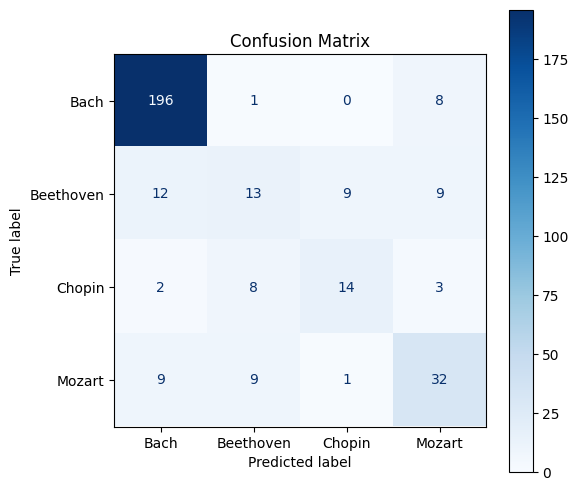

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              77.6%      10.2%       1.5%      10.7%
Beethoven         16.3%      58.1%      11.6%      14.0%
Chopin             0.0%      37.0%      59.3%       3.7%
Mozart             3.9%      56.9%       3.9%      35.3%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.9464    0.7756    0.8525       205
   Beethoven     0.2941    0.5814    0.3906        43
      Chopin     0.6154    0.5926    0.6038        27
      Mozart     0.3830    0.3529    0.3673        51

    accuracy                         0.6687       326
   macro avg     0.5597    0.5756    0.5536       326
weighted avg     0.7448    0.6687    0.6951       326

Validation Accuracy: 0.6687


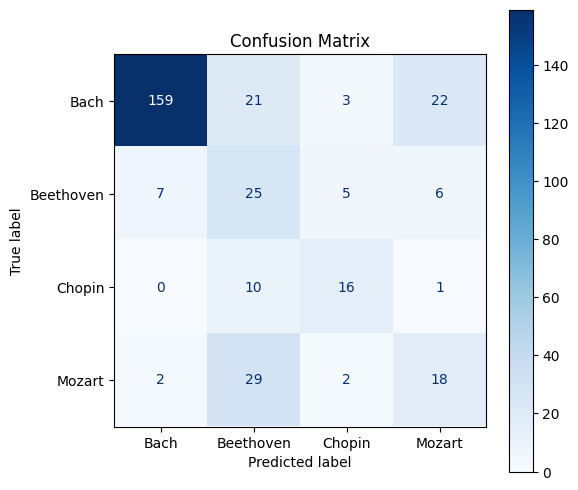

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              88.8%       5.9%       1.0%       4.4%
Beethoven         18.6%      58.1%       7.0%      16.3%
Chopin             0.0%      22.2%      55.6%      22.2%
Mozart            11.8%      23.5%       7.8%      56.9%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.9286    0.8878    0.9077       205
   Beethoven     0.4545    0.5814    0.5102        43
      Chopin     0.6250    0.5556    0.5882        27
      Mozart     0.5686    0.5686    0.5686        51

    accuracy                         0.7699       326
   macro avg     0.6442    0.6483    0.6437       326
weighted avg     0.7846    0.7699    0.7758       326

Validation Accuracy: 0.7699


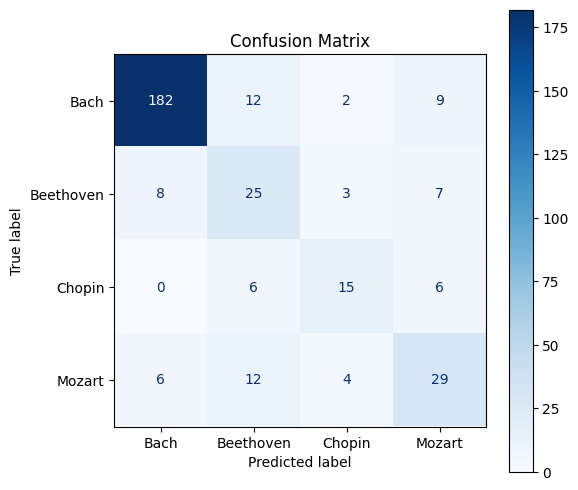

c:\JupyterNotebooks\AAI511_Final_Project_Group1\utils_Sean.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              93.7%       0.5%       3.4%       2.4%
Beethoven         34.9%      25.6%      20.9%      18.6%
Chopin             7.4%       3.7%      81.5%       7.4%
Mozart            21.6%      15.7%      21.6%      41.2%

Note: Rows = Actual, Columns = Predicted

Classification Report:
              precision    recall  f1-score   support

        Bach     0.8727    0.9366    0.9035       205
   Beethoven     0.5238    0.2558    0.3438        43
      Chopin     0.4490    0.8148    0.5789        27
      Mozart     0.5833    0.4118    0.4828        51

    accuracy                         0.7546       326
   macro avg     0.6072    0.6047    0.5772       326
weighted avg     0.7463    0.7546    0.7370       326

Validation Accuracy: 0.7546


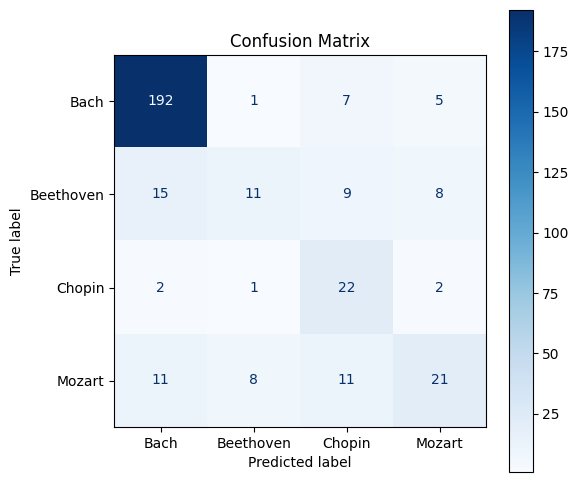

In [8]:
class_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

evaluate_confusion_matrix(model1, val_loader, device, class_names)
evaluate_confusion_matrix(model2, val_loader, device, class_names)
evaluate_confusion_matrix(model3, val_loader, device, class_names)
evaluate_confusion_matrix(model4, val_loader, device, class_names)